# Processing Numeric Features

So far, I've performed some basic descriptive analysis and analyzed pure premium to help deal with outlier observations both big and small outliers). I now turn the attention towards processing features. In this document, I'll focus solely on numeric features.

In the data_eda notebook, I noted that several of the numeric features were skewed and many had non-straight line relationships with the target variables. The non-straight line relationships make the variables decent candidates for splines, which are piecewise polynomial functions. I like to use capping and flooring on extreme values to build my splines to deal with thin extreme values. I'll demonstrate that here.

The methodology is as follows:

1) Cap/floor the variable at the 2.5th and 97.5th weighted percentiles. Fill NA values with the median (there aren't any in this dataset).
2) Create a categorical indicator field that an observation has been capped/floored/imputed. 
3) Get a list of the unique weighted deciles. These are the potential placements for a knot.
4) Make a unique grid of these candidate placements and combinations of up to 1, 2, 3 or 4 total knots.
5) Three additional scenarios are considered: straight-line, quadratic and cubic polynomial fits.
6) A cross-validation process is run for each of the scenarios. The mean Tweedie deviance is recorded.
7) The scenario with the minimized Tweedie deviance is the "best" one to use.

This methodology is somewhat flawed. One of the problems (similar to the capping_levels notebook) is that I do not yet have a final model formula figured out- again, I argue that it is too difficult to experiment with all moving pieces all at the same time. Secondly, it only considers a single variable at a time. Ideally, I'd be trying to tune every single numeric feature's spline fit all at the same time. This is a tremendously time consuming calculation, therefore I avoid it. The [MARS procedure](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_spline) is an acceptable alternative that overcomes this limitation. I'm comfortable doing this 1-variable approach for this use case simply because the variables are not too correlated and I plan to later use other regularization methods to prevent overfitting.

# Packages and Settings

In [41]:
import pandas as pd 
import numpy as np 

from joblib import Parallel, delayed
from pathlib import Path
from utils import *

# Import Data

In [42]:
df = pd.read_parquet("data/df_train_target.parquet") # final output from prior capping_levels notebook

In [43]:
all_cols = [
  'Area',
  'VehPower',
  'VehAge',
  'DrivAge',
  'BonusMalus',
  'VehBrand',
  'VehGas',
  'Density',
  'Region'
]

num_cols = list(df[all_cols].select_dtypes(include=[np.number]).columns)
cat_cols = list(df[all_cols].select_dtypes(exclude=[np.number]).columns)
print(f"Numerics: {len(num_cols)} | Categoricals: {len(cat_cols)}")

Numerics: 5 | Categoricals: 4


# VehPower

First, I'll pull up a 1-way chart:

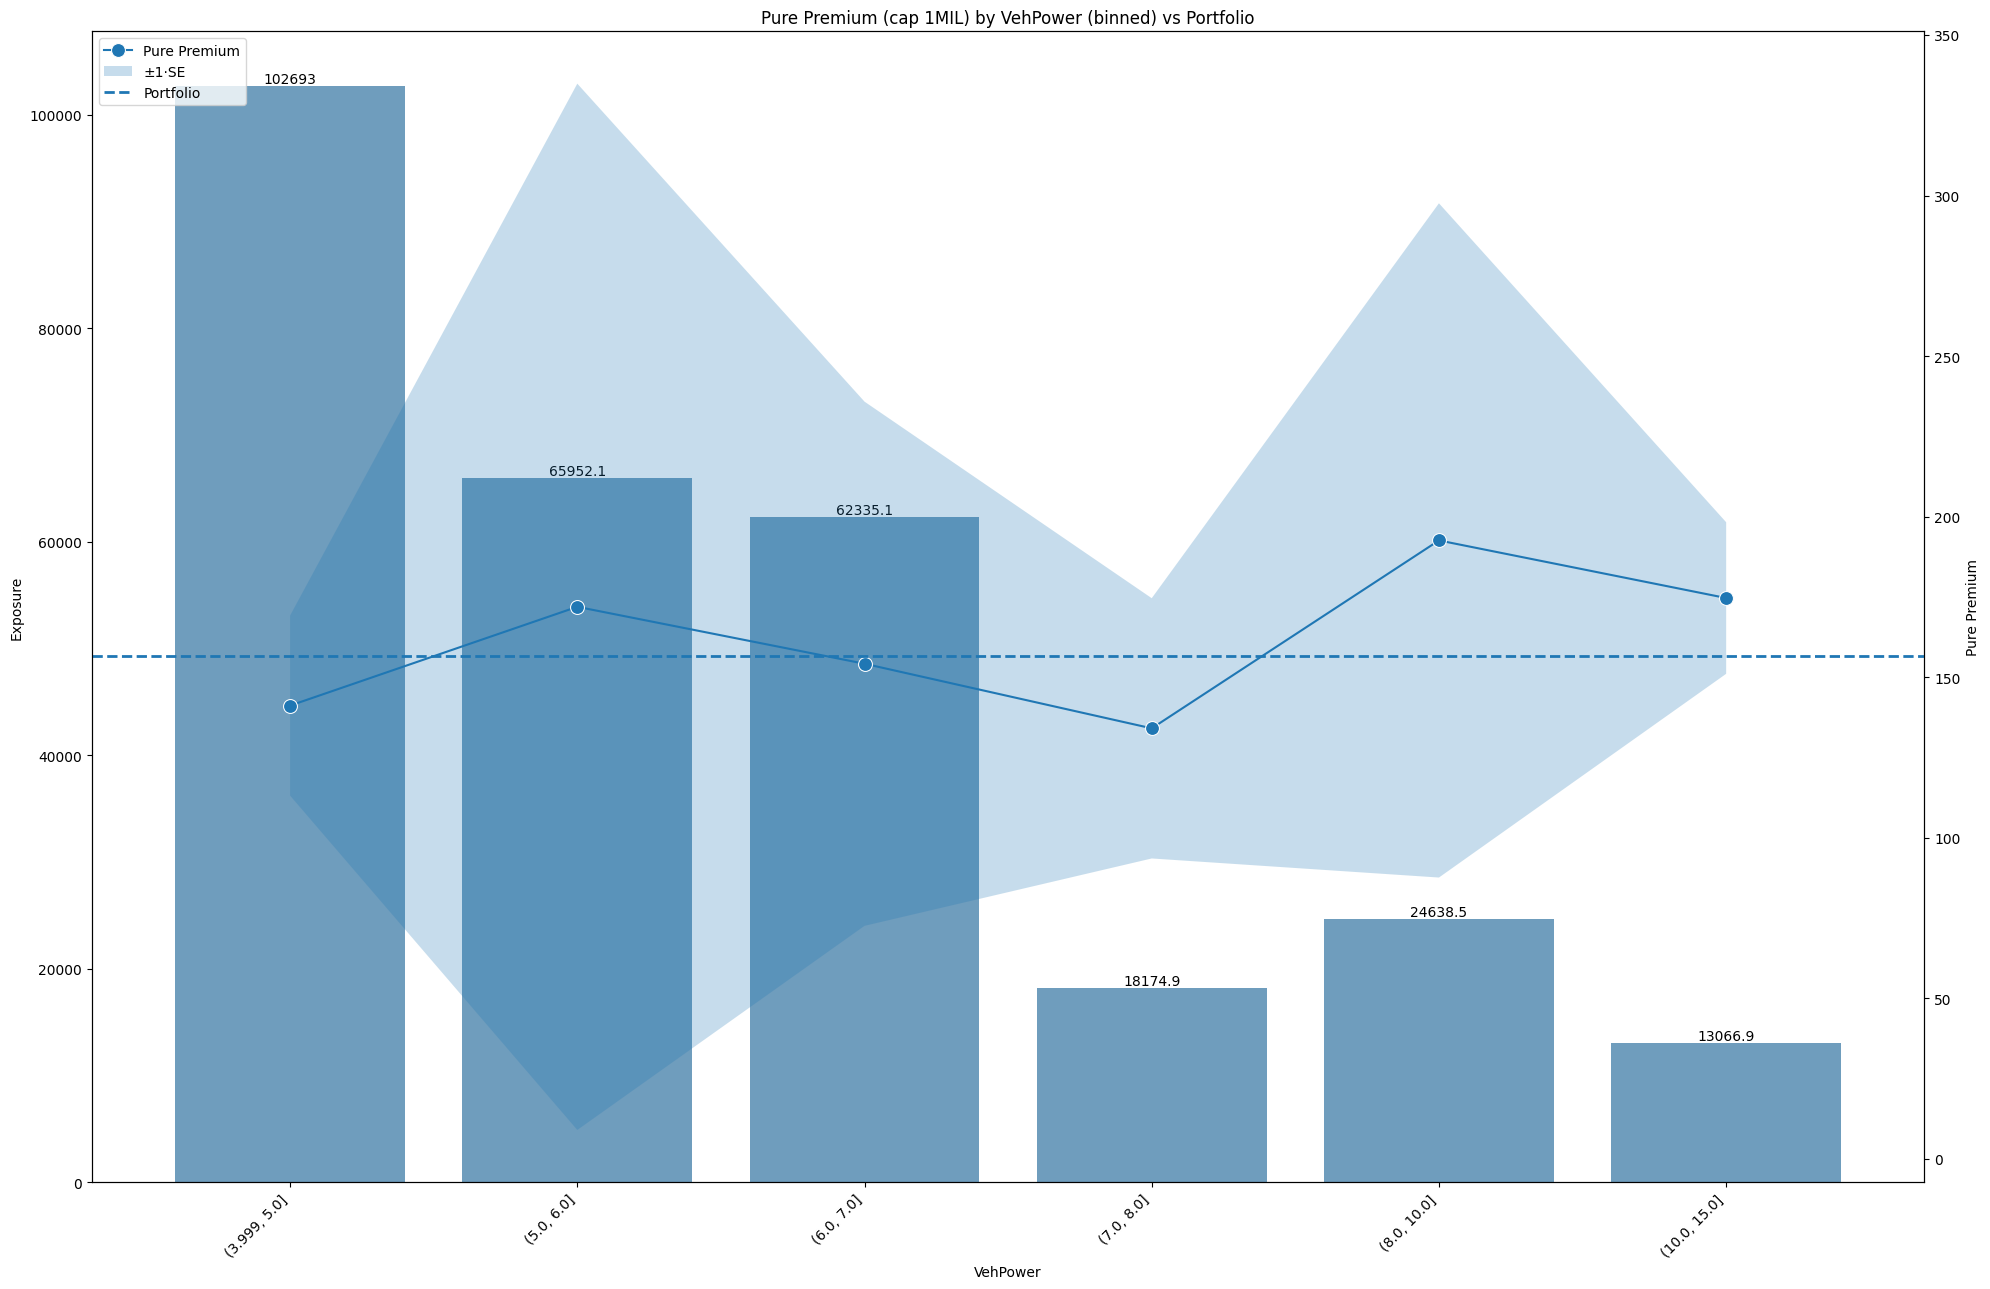

In [44]:
fig = runmultiplot(df, "VehPower", metric="Pure Premium", cap=1000000)

It is interesting that there seems not to be a clear trend here. It is obvious very high-powered vehicles have higher pure premium. Everything else doesn't clearly have much differentiation though.

In [45]:
probs = [0.025, 0.975]
percentiles = weighted_percentiles(df, "VehPower", "Exposure", probs)
p_lo, p_hi = float(percentiles.loc[0.025]), float(percentiles.loc[0.975])
df["VehPower_capped"] = df["VehPower"].clip(lower=p_lo, upper=p_hi)
cond = [
  df["VehPower"] < p_lo,
  df["VehPower"] > p_hi
]
choice = ["floored", "capped"]
indicator = np.select(cond, choice, default="valid")
df["VehPower_cap_flag"] = pd.Categorical(
  indicator, categories=["floored", "capped", "valid"]
)

decile_probs = [i/10 for i in range(1, 10)]  # 0.1, 0.2, ..., 0.9
deciles = weighted_percentiles(df, "VehPower", "Exposure", decile_probs)
candidates = np.unique(deciles.dropna().to_numpy())
vmin = float(df["VehPower_capped"].min())
vmax = float(df["VehPower_capped"].max())
mask = ~(np.isclose(candidates, vmin, rtol=1e-9, atol=1e-12) |
         np.isclose(candidates, vmax, rtol=1e-9, atol=1e-12))
candidates = candidates[mask]
knot_grid = make_knot_grid(
    candidates=candidates,
    knot_counts=(1, 2, 3, 4), 
    min_space=2,
    spacing_units="absolute"
)

knot_grid_wide = expand_knots_df(knot_grid)

# Inspect
print("Candidates:", candidates)
print(knot_grid_wide)

Candidates: [5. 6. 7. 9.]
   n_knots  knot1  knot2  knot3
0        1    5.0    NaN    NaN
1        1    6.0    NaN    NaN
2        1    7.0    NaN    NaN
3        1    9.0    NaN    NaN
4        2    5.0    7.0    NaN
5        2    5.0    9.0    NaN
6        2    6.0    9.0    NaN
7        2    7.0    9.0    NaN
8        3    5.0    7.0    9.0


In [46]:
# Choose what variable gets the spline + what the target is
N_JOBS = 3
FROM_BACKUP = True
X_COL = "VehPower_capped"
Y_COL = "pure_premium_capped_1MIL"
P_FIXED = 1.94

# Baselines
scenario_list = [
    {"kind": "linear",    "label": "linear"},
    {"kind": "quadratic", "label": "quadratic"},
    {"kind": "cubic",     "label": "cubic"},
]

# Splines from knot_grid_wide
for row in knot_grid_wide.to_dict(orient="records"):
    knots = row_knots(row)
    scenario_list.append({
        "kind": "spline",
        "label": f"spline_n{int(row['n_knots'])}_{knots}",
        "n_knots": int(row["n_knots"]),
        "knots": knots,
    })

if (not FROM_BACKUP) or (not Path("data/splines/vehpower_grid.parquet").exists()): 
  results = Parallel(n_jobs=N_JOBS, backend="loky")(
    delayed(evaluate_spline_scenario_cv)(
        scenario=sc,
        df=df,
        x_col=X_COL,
        y_col=Y_COL,
        p_fixed=P_FIXED,
        weight_col="Exposure",
        spline_degree=3,
    )
    for sc in scenario_list
)

  vehpower_grid = pd.DataFrame(results).sort_values("score")
  vehpower_grid.to_parquet("data/splines/vehpower_grid.parquet")
else:
  vehpower_grid = pd.read_parquet("data/splines/vehpower_grid.parquet")


And the best VehPower scenario is:

In [47]:
vehpower_grid.sort_values("score")["label"].iloc[0]

'linear'

Ah! So in this case, a straight line is perfectly fine. Not surprising, given the 1-way view above. 

# VehAge

First, I'll pull up a 1-way chart:

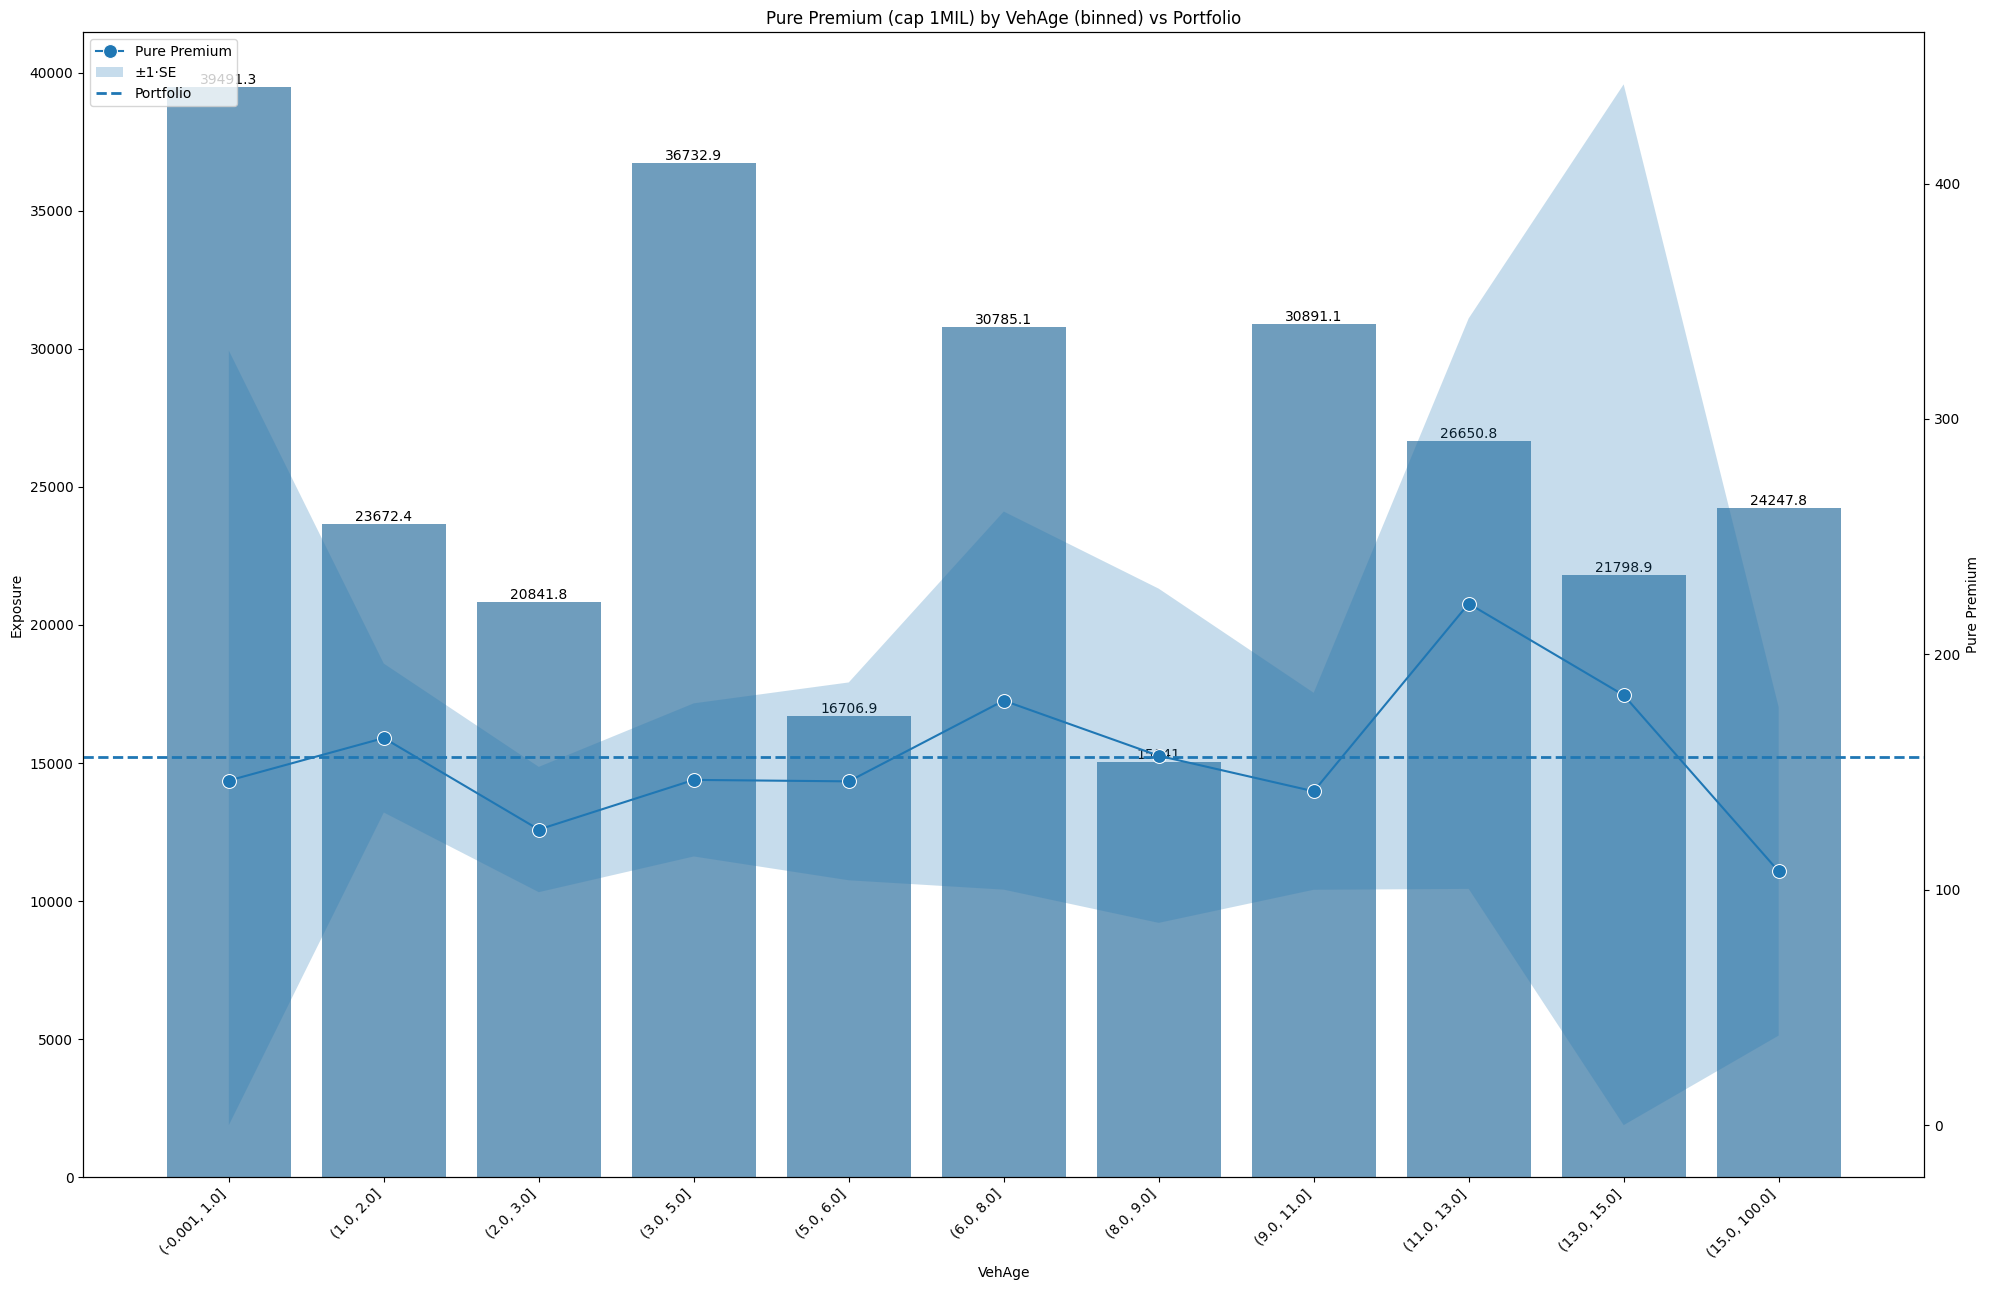

In [48]:
fig = runmultiplot(df, "VehAge", metric="Pure Premium", cap=1000000)

It is interesting that there seems not to be a clear trend here. It is obvious very high-powered vehicles have higher pure premium. Everything else doesn't clearly have much differentiation though.

In [49]:
probs = [0.025, 0.975]
percentiles = weighted_percentiles(df, "VehAge", "Exposure", probs)
p_lo, p_hi = float(percentiles.loc[0.025]), float(percentiles.loc[0.975])
df["VehAge_capped"] = df["VehAge"].clip(lower=p_lo, upper=p_hi)
cond = [
  df["VehAge"] < p_lo,
  df["VehAge"] > p_hi
]
choice = ["floored", "capped"]
indicator = np.select(cond, choice, default="valid")
df["VehAge_cap_flag"] = pd.Categorical(
  indicator, categories=["floored", "capped", "valid"]
)

decile_probs = [i/20 for i in range(1, 10)]  # 0.1, 0.2, ..., 0.9
deciles = weighted_percentiles(df, "VehAge", "Exposure", decile_probs)
candidates = np.unique(deciles.dropna().to_numpy())
vmin = float(df["VehAge_capped"].min())
vmax = float(df["VehAge_capped"].max())
mask = ~(np.isclose(candidates, vmin, rtol=1e-9, atol=1e-12) |
         np.isclose(candidates, vmax, rtol=1e-9, atol=1e-12))
candidates = candidates[mask]
knot_grid = make_knot_grid(
    candidates=candidates,
    knot_counts=(1, 2, 3), 
    min_space=2,
    spacing_units="absolute"
)

knot_grid_wide = expand_knots_df(knot_grid)

# Inspect
print("Candidates:", candidates)
print(knot_grid_wide)

Candidates: [1. 2. 3. 4. 5. 6.]
    n_knots  knot1  knot2  knot3
0         1    1.0    NaN    NaN
1         1    2.0    NaN    NaN
2         1    3.0    NaN    NaN
3         1    4.0    NaN    NaN
4         1    5.0    NaN    NaN
5         1    6.0    NaN    NaN
6         2    1.0    3.0    NaN
7         2    1.0    4.0    NaN
8         2    1.0    5.0    NaN
9         2    1.0    6.0    NaN
10        2    2.0    4.0    NaN
11        2    2.0    5.0    NaN
12        2    2.0    6.0    NaN
13        2    3.0    5.0    NaN
14        2    3.0    6.0    NaN
15        2    4.0    6.0    NaN
16        3    1.0    3.0    5.0
17        3    1.0    3.0    6.0
18        3    1.0    4.0    6.0
19        3    2.0    4.0    6.0


In [50]:
# Choose what variable gets the spline + what the target is
N_JOBS = 3
FROM_BACKUP = True
X_COL = "VehAge_capped"
Y_COL = "pure_premium_capped_1MIL"
P_FIXED = 1.94

# Baselines
scenario_list = [
    {"kind": "linear",    "label": "linear"},
    {"kind": "quadratic", "label": "quadratic"},
    {"kind": "cubic",     "label": "cubic"},
]

# Splines from knot_grid_wide
for row in knot_grid_wide.to_dict(orient="records"):
    knots = row_knots(row)
    scenario_list.append({
        "kind": "spline",
        "label": f"spline_n{int(row['n_knots'])}_{knots}",
        "n_knots": int(row["n_knots"]),
        "knots": knots,
    })

if (not FROM_BACKUP) or (not Path("data/splines/vehage_grid.parquet").exists()): 
  results = Parallel(n_jobs=N_JOBS, backend="loky")(
    delayed(evaluate_spline_scenario_cv)(
        scenario=sc,
        df=df,
        x_col=X_COL,
        y_col=Y_COL,
        p_fixed=P_FIXED,
        weight_col="Exposure",
        spline_degree=3,
    )
    for sc in scenario_list
)

  vehage_grid = pd.DataFrame(results).sort_values("score")
  vehage_grid.to_parquet("data/splines/vehage_grid.parquet")
else:
  vehage_grid = pd.read_parquet("data/splines/vehage_grid.parquet")


And the best VehAge scenario is:

In [51]:
vehage_grid.sort_values("score")["label"].iloc[0]

'spline_n1_(3.0,)'

# DrivAge

First, I'll pull up a 1-way chart:

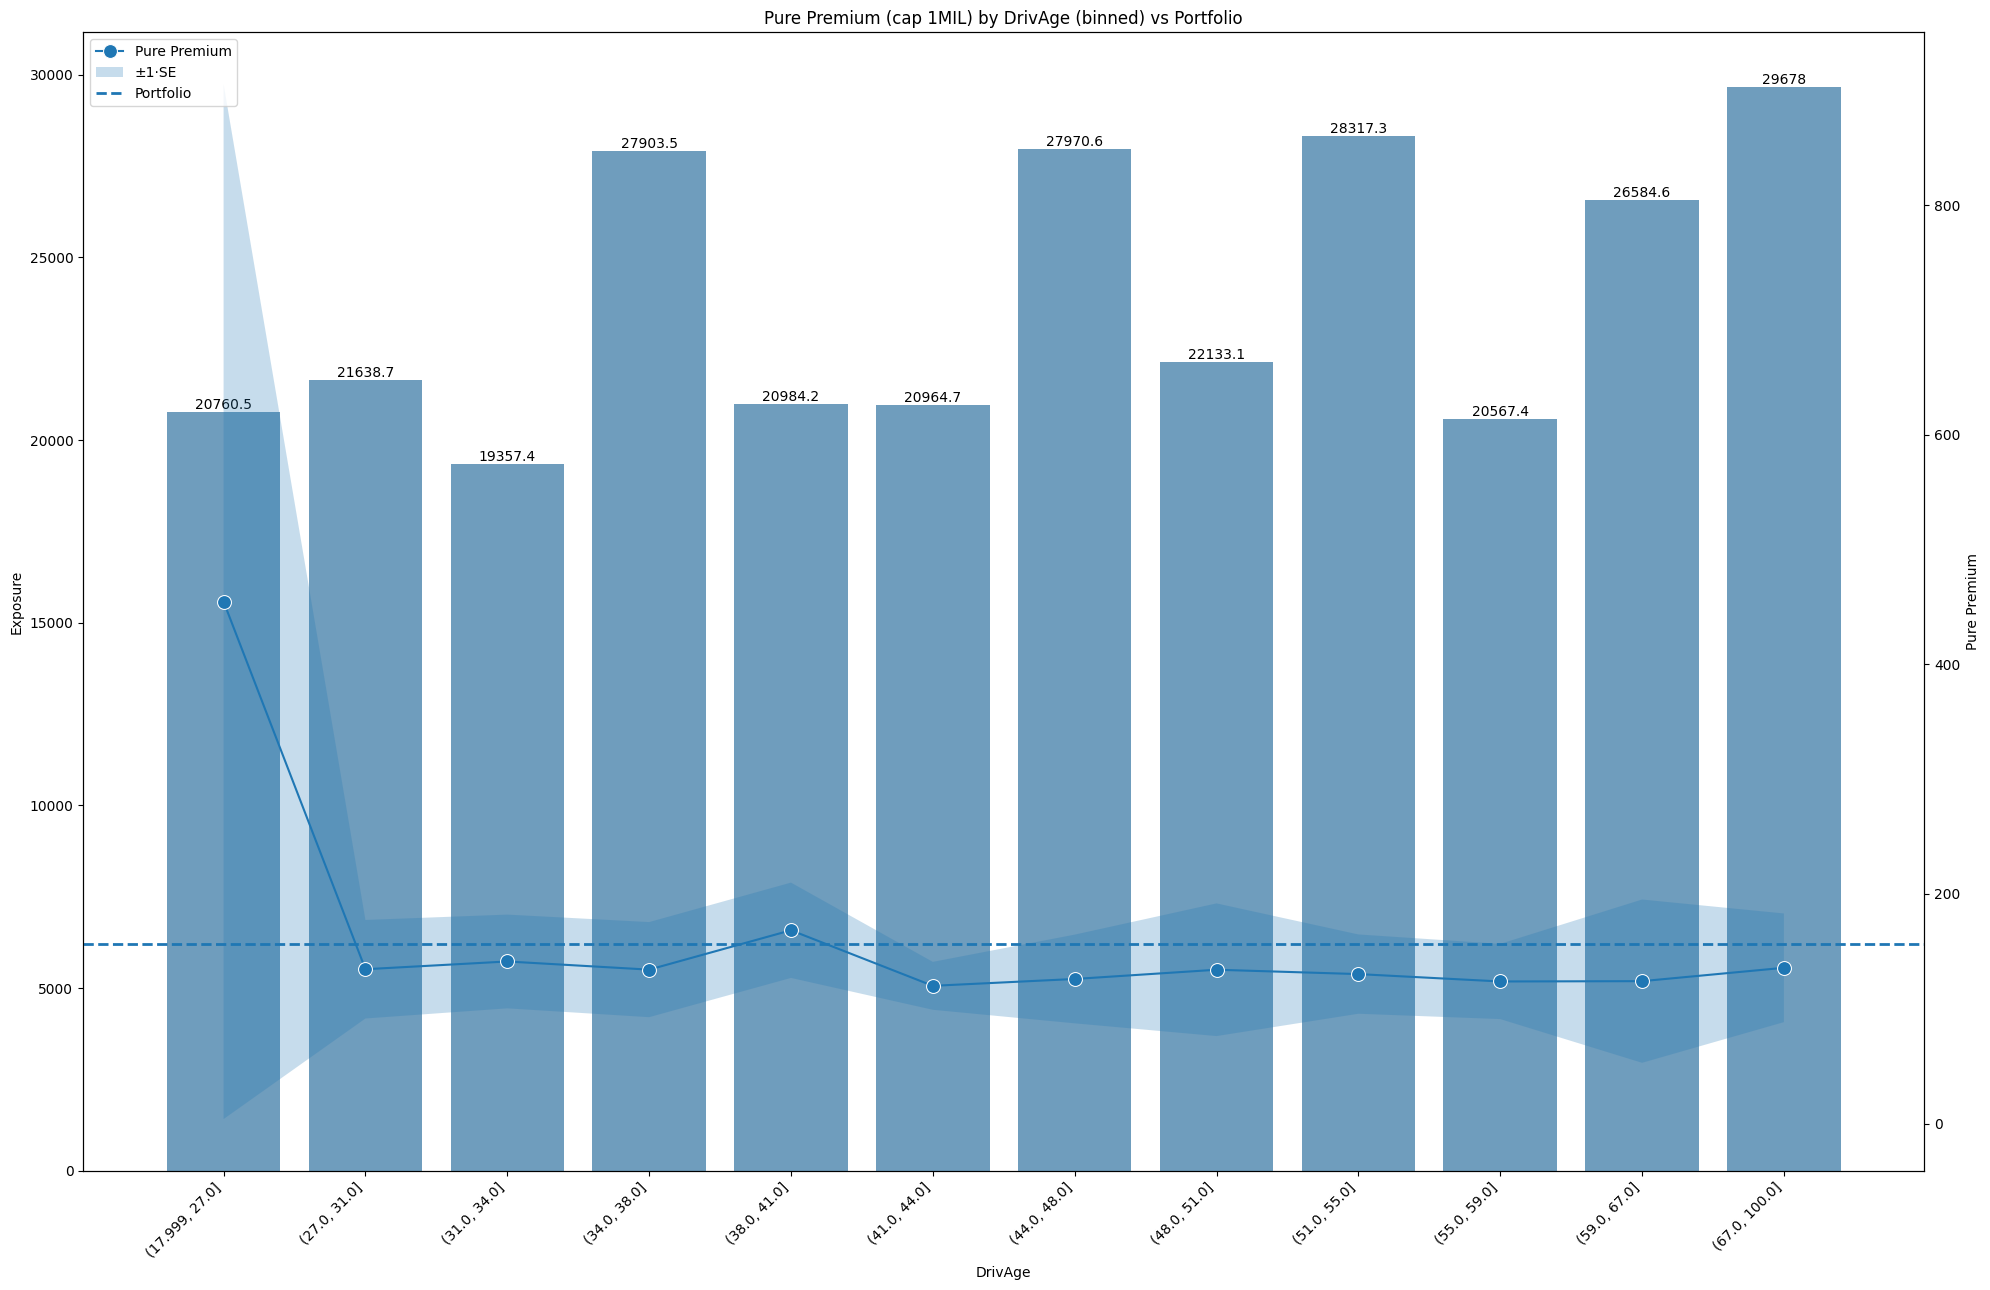

In [52]:
fig = runmultiplot(df, "DrivAge", metric="Pure Premium", cap=1000000)

It is interesting that there seems not to be a clear trend here. It is obvious very high-powered vehicles have higher pure premium. Everything else doesn't clearly have much differentiation though.

In [53]:
probs = [0.025, 0.975]
percentiles = weighted_percentiles(df, "DrivAge", "Exposure", probs)
p_lo, p_hi = float(percentiles.loc[0.025]), float(percentiles.loc[0.975])
df["DrivAge_capped"] = df["DrivAge"].clip(lower=p_lo, upper=p_hi)
cond = [
  df["DrivAge"] < p_lo,
  df["DrivAge"] > p_hi
]
choice = ["floored", "capped"]
indicator = np.select(cond, choice, default="valid")
df["DrivAge_cap_flag"] = pd.Categorical(
  indicator, categories=["floored", "capped", "valid"]
)

decile_probs = [i/20 for i in range(1, 10)]  # 0.1, 0.2, ..., 0.9
deciles = weighted_percentiles(df, "DrivAge", "Exposure", decile_probs)
candidates = np.unique(deciles.dropna().to_numpy())
vmin = float(df["DrivAge_capped"].min())
vmax = float(df["DrivAge_capped"].max())
mask = ~(np.isclose(candidates, vmin, rtol=1e-9, atol=1e-12) |
         np.isclose(candidates, vmax, rtol=1e-9, atol=1e-12))
candidates = candidates[mask]
knot_grid = make_knot_grid(
    candidates=candidates,
    knot_counts=(1, 2, 3), 
    min_space=3,
    spacing_units="absolute"
)

knot_grid_wide = expand_knots_df(knot_grid)

# Inspect
print("Candidates:", candidates)
print(knot_grid_wide)

Candidates: [26. 29. 32. 34. 36. 38. 40. 42. 44.]
    n_knots  knot1  knot2  knot3
0         1   26.0    NaN    NaN
1         1   29.0    NaN    NaN
2         1   32.0    NaN    NaN
3         1   34.0    NaN    NaN
4         1   36.0    NaN    NaN
..      ...    ...    ...    ...
81        3   32.0   40.0   44.0
82        3   34.0   38.0   42.0
83        3   34.0   38.0   44.0
84        3   34.0   40.0   44.0
85        3   36.0   40.0   44.0

[86 rows x 4 columns]


In [54]:
# Choose what variable gets the spline + what the target is
N_JOBS = 6
FROM_BACKUP = True
X_COL = "DrivAge_capped"
Y_COL = "pure_premium_capped_1MIL"
P_FIXED = 1.94

# Baselines
scenario_list = [
    {"kind": "linear",    "label": "linear"},
    {"kind": "quadratic", "label": "quadratic"},
    {"kind": "cubic",     "label": "cubic"},
]

# Splines from knot_grid_wide
for row in knot_grid_wide.to_dict(orient="records"):
    knots = row_knots(row)
    scenario_list.append({
        "kind": "spline",
        "label": f"spline_n{int(row['n_knots'])}_{knots}",
        "n_knots": int(row["n_knots"]),
        "knots": knots,
    })

if (not FROM_BACKUP) or (not Path("data/splines/drage_grid.parquet").exists()): 
  results = Parallel(n_jobs=N_JOBS, backend="loky")(
    delayed(evaluate_spline_scenario_cv)(
        scenario=sc,
        df=df,
        x_col=X_COL,
        y_col=Y_COL,
        p_fixed=P_FIXED,
        weight_col="Exposure",
        spline_degree=3,
    )
    for sc in scenario_list
)

  drage_grid = pd.DataFrame(results).sort_values("score")
  drage_grid.to_parquet("data/splines/drage_grid.parquet")
else:
  drage_grid = pd.read_parquet("data/splines/drage_grid.parquet")


And the best DrAge scenario is:

In [55]:
drage_grid.sort_values("score")["label"].iloc[0]

'spline_n3_(26.0, 29.0, 32.0)'

# BonusMalus

First, I'll pull up a 1-way chart:

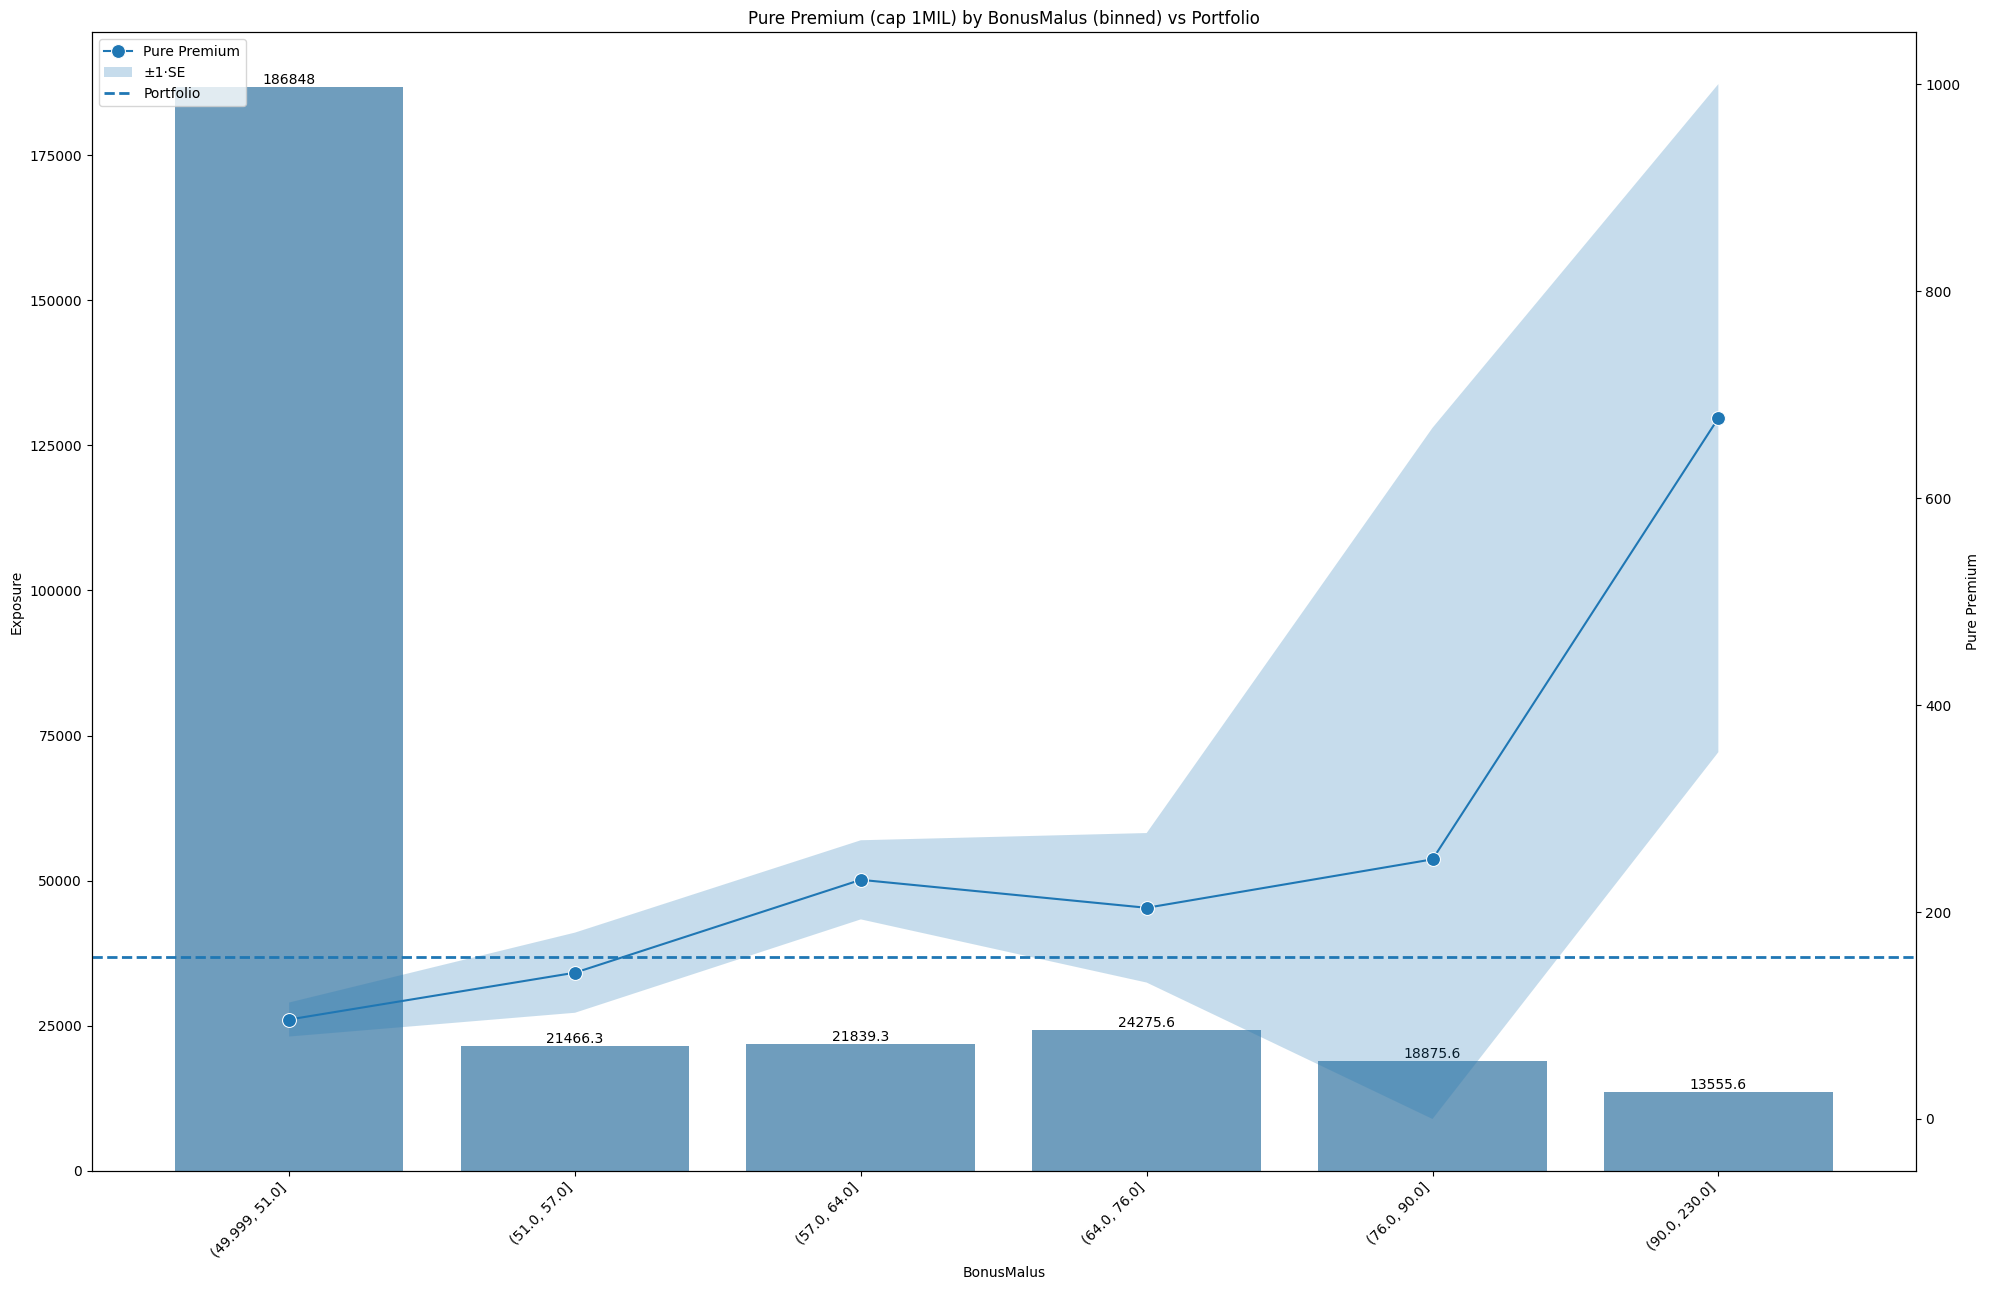

In [56]:
fig = runmultiplot(df, "BonusMalus", metric="Pure Premium", cap=1000000)

It is interesting that there seems not to be a clear trend here. It is obvious very high-powered vehicles have higher pure premium. Everything else doesn't clearly have much differentiation though.

In [57]:
probs = [0.025, 0.975]
percentiles = weighted_percentiles(df, "BonusMalus", "Exposure", probs)
p_lo, p_hi = float(percentiles.loc[0.025]), float(percentiles.loc[0.975])
df["BonusMalus_capped"] = df["BonusMalus"].clip(lower=p_lo, upper=p_hi)
cond = [
  df["BonusMalus"] < p_lo,
  df["BonusMalus"] > p_hi
]
choice = ["floored", "capped"]
indicator = np.select(cond, choice, default="valid")
df["BonusMalus_cap_flag"] = pd.Categorical(
  indicator, categories=["floored", "capped", "valid"]
)

decile_probs = [i/10 for i in range(1, 10)]  # 0.1, 0.2, ..., 0.9
deciles = weighted_percentiles(df, "BonusMalus", "Exposure", decile_probs)
candidates = np.unique(deciles.dropna().to_numpy())
vmin = float(df["BonusMalus_capped"].min())
vmax = float(df["BonusMalus_capped"].max())
mask = ~(np.isclose(candidates, vmin, rtol=1e-9, atol=1e-12) |
         np.isclose(candidates, vmax, rtol=1e-9, atol=1e-12))
candidates = candidates[mask]
knot_grid = make_knot_grid(
    candidates=candidates,
    knot_counts=(1, 2, 3, 4), 
    min_space=2,
    spacing_units="absolute"
)

knot_grid_wide = expand_knots_df(knot_grid)

# Inspect
print("Candidates:", candidates)
print(knot_grid_wide)

Candidates: [56. 64. 80.]
   n_knots  knot1  knot2  knot3
0        1   56.0    NaN    NaN
1        1   64.0    NaN    NaN
2        1   80.0    NaN    NaN
3        2   56.0   64.0    NaN
4        2   56.0   80.0    NaN
5        2   64.0   80.0    NaN
6        3   56.0   64.0   80.0


In [58]:
# Choose what variable gets the spline + what the target is
N_JOBS = 3
FROM_BACKUP = True
X_COL = "BonusMalus_capped"
Y_COL = "pure_premium_capped_1MIL"
P_FIXED = 1.94

# Baselines
scenario_list = [
    {"kind": "linear",    "label": "linear"},
    {"kind": "quadratic", "label": "quadratic"},
    {"kind": "cubic",     "label": "cubic"},
]

# Splines from knot_grid_wide
for row in knot_grid_wide.to_dict(orient="records"):
    knots = row_knots(row)
    scenario_list.append({
        "kind": "spline",
        "label": f"spline_n{int(row['n_knots'])}_{knots}",
        "n_knots": int(row["n_knots"]),
        "knots": knots,
    })

if (not FROM_BACKUP) or (not Path("data/splines/bonusmalus_grid.parquet").exists()): 
  results = Parallel(n_jobs=N_JOBS, backend="loky")(
    delayed(evaluate_spline_scenario_cv)(
        scenario=sc,
        df=df,
        x_col=X_COL,
        y_col=Y_COL,
        p_fixed=P_FIXED,
        weight_col="Exposure",
        spline_degree=3,
    )
    for sc in scenario_list
)

  bonusmalus_grid = pd.DataFrame(results).sort_values("score")
  bonusmalus_grid.to_parquet("data/splines/bonusmalus_grid.parquet")
else:
  bonusmalus_grid = pd.read_parquet("data/splines/bonusmalus_grid.parquet")


And the best BonusMalus scenario is:

In [59]:
bonusmalus_grid.sort_values("score")["label"].iloc[0]

'spline_n1_(80.0,)'

# Density

First, I'll pull up a 1-way chart:

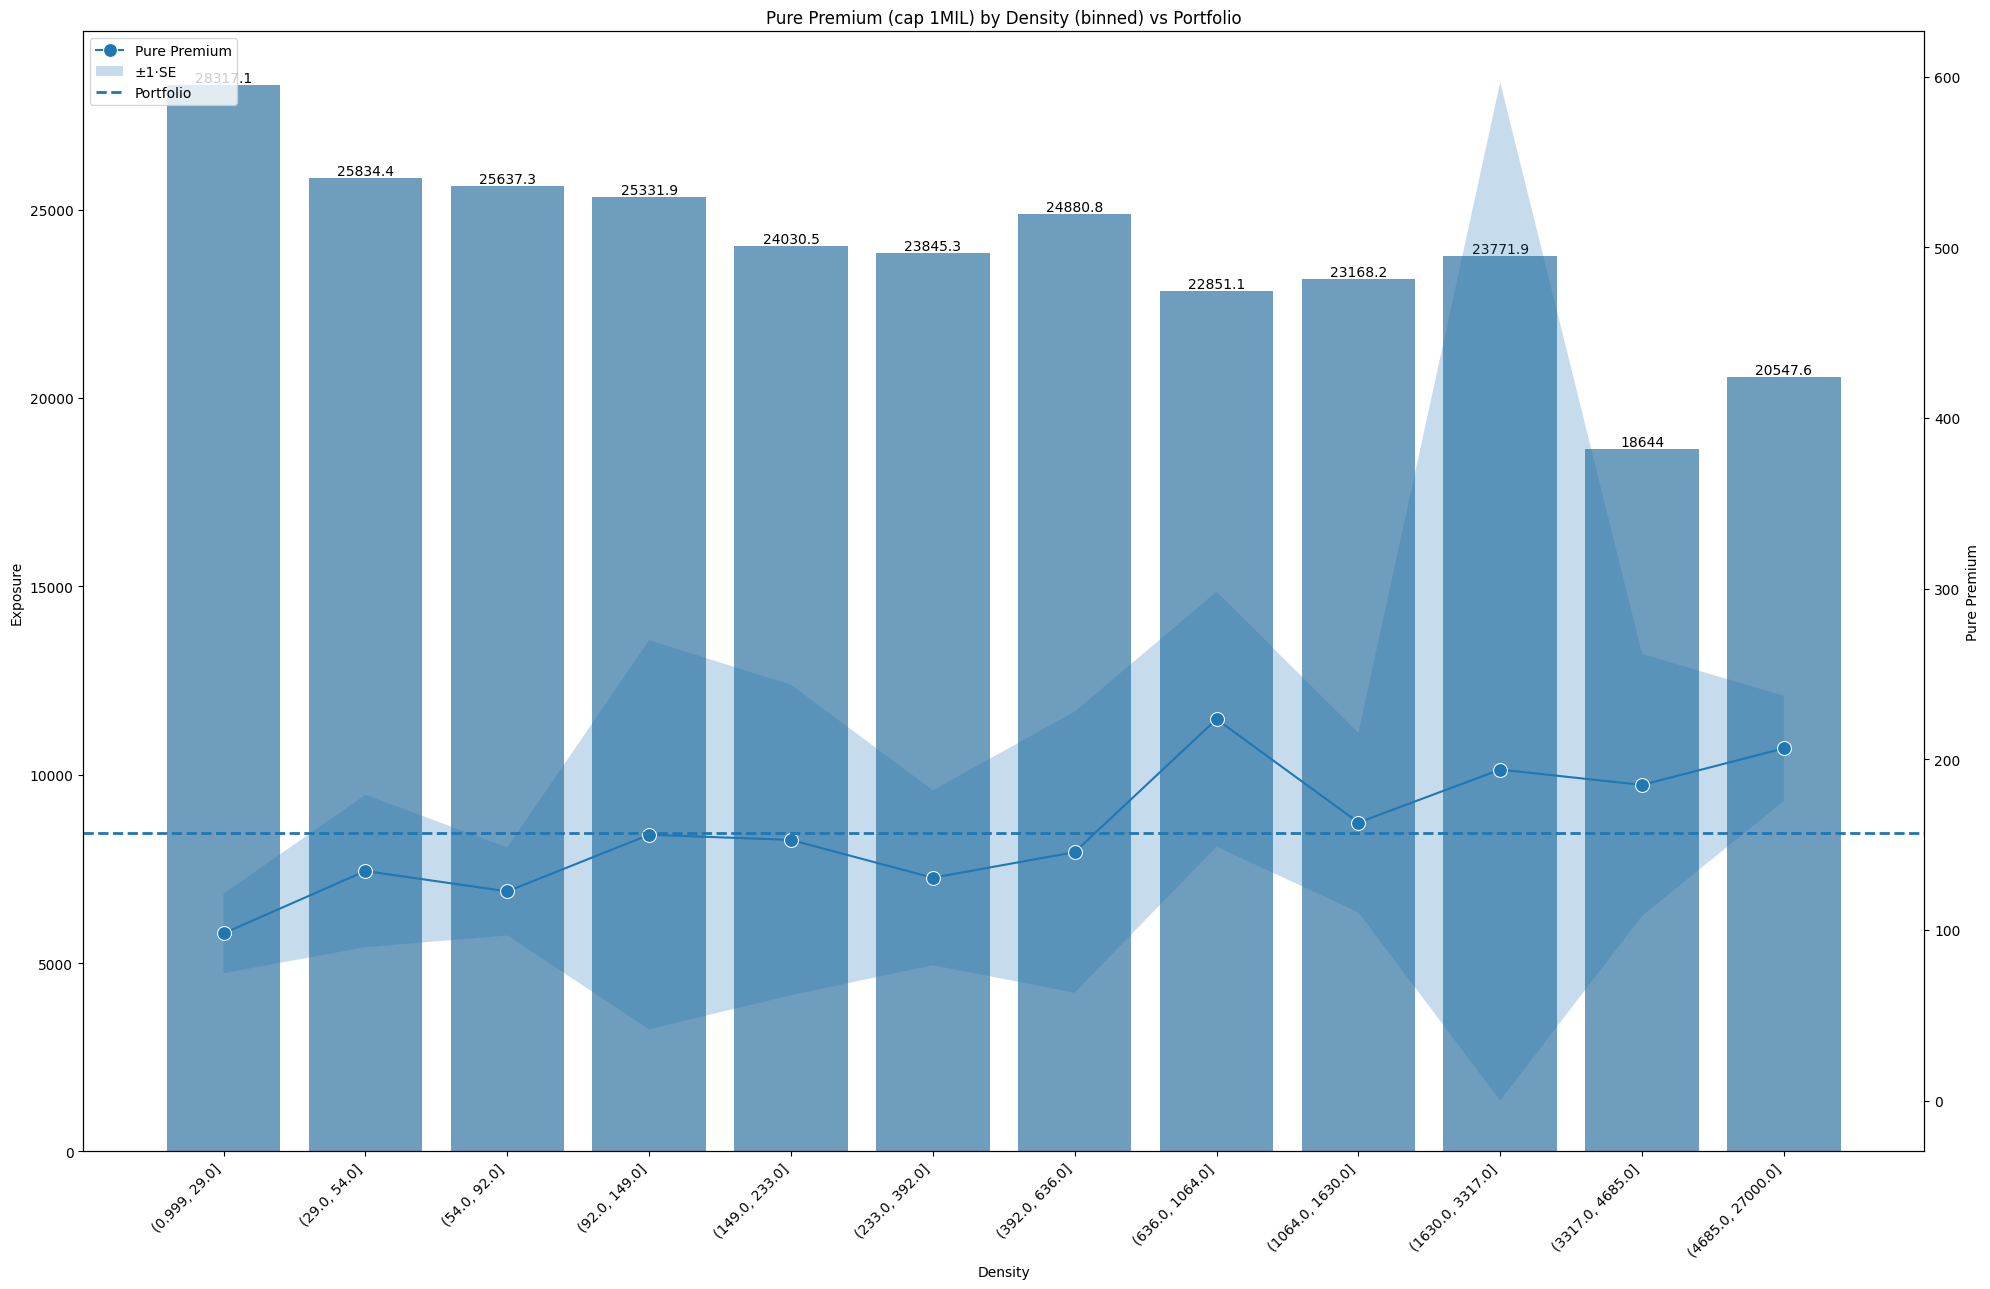

In [60]:
fig = runmultiplot(df, "Density", metric="Pure Premium", cap=1000000)

It is interesting that there seems not to be a clear trend here. It is obvious very high-powered vehicles have higher pure premium. Everything else doesn't clearly have much differentiation though.

In [61]:
probs = [0.025, 0.975]
percentiles = weighted_percentiles(df, "Density", "Exposure", probs)
p_lo, p_hi = float(percentiles.loc[0.025]), float(percentiles.loc[0.975])
df["Density_capped"] = df["Density"].clip(lower=p_lo, upper=p_hi)
cond = [
  df["Density"] < p_lo,
  df["Density"] > p_hi
]
choice = ["floored", "capped"]
indicator = np.select(cond, choice, default="valid")
df["Density_cap_flag"] = pd.Categorical(
  indicator, categories=["floored", "capped", "valid"]
)

decile_probs = [i/20 for i in range(1, 10)]  # 0.1, 0.2, ..., 0.9
deciles = weighted_percentiles(df, "Density", "Exposure", decile_probs)
candidates = np.unique(deciles.dropna().to_numpy())
vmin = float(df["Density_capped"].min())
vmax = float(df["Density_capped"].max())
mask = ~(np.isclose(candidates, vmin, rtol=1e-9, atol=1e-12) |
         np.isclose(candidates, vmax, rtol=1e-9, atol=1e-12))
candidates = candidates[mask]
knot_grid = make_knot_grid(
    candidates=candidates,
    knot_counts=(1, 2, 3), 
    min_space=4,
    spacing_units="absolute"
)

knot_grid_wide = expand_knots_df(knot_grid)

# Inspect
print("Candidates:", candidates)
print(knot_grid_wide)

Candidates: [ 18.  30.  44.  57.  79. 104. 136. 182. 233.]
     n_knots  knot1  knot2  knot3
0          1   18.0    NaN    NaN
1          1   30.0    NaN    NaN
2          1   44.0    NaN    NaN
3          1   57.0    NaN    NaN
4          1   79.0    NaN    NaN
..       ...    ...    ...    ...
124        3   79.0  182.0  233.0
125        3  104.0  136.0  182.0
126        3  104.0  136.0  233.0
127        3  104.0  182.0  233.0
128        3  136.0  182.0  233.0

[129 rows x 4 columns]


In [62]:
# Choose what variable gets the spline + what the target is
N_JOBS = 6
FROM_BACKUP = True
X_COL = "Density_capped"
Y_COL = "pure_premium_capped_1MIL"
P_FIXED = 1.94

# Baselines
scenario_list = [
    {"kind": "linear",    "label": "linear"},
    {"kind": "quadratic", "label": "quadratic"},
    {"kind": "cubic",     "label": "cubic"},
]

# Splines from knot_grid_wide
for row in knot_grid_wide.to_dict(orient="records"):
    knots = row_knots(row)
    scenario_list.append({
        "kind": "spline",
        "label": f"spline_n{int(row['n_knots'])}_{knots}",
        "n_knots": int(row["n_knots"]),
        "knots": knots,
    })

if (not FROM_BACKUP) or (not Path("data/splines/density_grid.parquet").exists()): 
  results = Parallel(n_jobs=N_JOBS, backend="loky")(
    delayed(evaluate_spline_scenario_cv)(
        scenario=sc,
        df=df,
        x_col=X_COL,
        y_col=Y_COL,
        p_fixed=P_FIXED,
        weight_col="Exposure",
        spline_degree=3,
    )
    for sc in scenario_list
)

  density_grid = pd.DataFrame(results).sort_values("score")
  density_grid.to_parquet("data/splines/density_grid.parquet")
else:
  density_grid = pd.read_parquet("data/splines/density_grid.parquet")


And the best Density scenario is:

In [63]:
density_grid.sort_values("score")["label"].iloc[0]

'spline_n1_(57.0,)'

# Export Data

In [64]:
df.to_parquet("data/df_train_numeric.parquet")

# Conclusions

Great! Now I have capped/floored versions of every numeric field with a categorical indicator if I've capped/floored it attached to my data. I also know the following spline parameterizations are the "best" to use in my model:

- VehPower: linear
- VehAge: Spline (3)
- DrivAge: Spline(26, 29, 32)
- BonusMalus: Spline (80)
- Density: Spline (57)

At this point, I have only 1 last pre-modeling step to complete: categorical features.
